# Final Project: Understanding Hired Rides in NYC - Group 12

## Project Setup

In [24]:
# all import statements needed for the project

import math
from math import tan
import geopandas
from geopandas import GeoSeries,GeoDataFrame

import re
import bs4
import requests
import urllib3
import pandas as pd
import matplotlib.pyplot as plt
from keplergl import KeplerGl
import sqlalchemy as db

In [25]:
# any general notebook setup, like log formatting

In [26]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

### Calculate Distance
- 1. Define a function that calculates the distance between two coordinates in kilometers that only uses the math module from the standard library
- 2. Use calculate_distance function to add distance column to each Uber and Yellow Taxi dataset

In [27]:
import math
from math import pi
EARTH_RADIUS = 6378.137
def rad(d):
    return d * pi / 180.0

def calculate_distance(from_coord, to_coord):
    lat1 = from_coord[0]
    lng1 = from_coord[1]
    lat2 = to_coord[0]
    lng2 = to_coord[1]
    radLat1 = rad(lat1)
    radLat2 = rad(lat2)
    a = radLat1 - radLat2
    b = rad(lng1) - rad(lng2)
    s = 2 * math.asin(
        math.sqrt(math.pow(math.sin(a / 2), 2) + math.cos(radLat1) * math.cos(radLat2) * math.pow(math.sin(b / 2), 2)))
    s = s * EARTH_RADIUS
    return s   

In [28]:
def add_distance_column(dataframe):
    distance_list = []
    for i in range(dataframe.shape[0]):
        from_coord  = (dataframe["pickup_latitude"][i], dataframe["pickup_longitude"][i])
        to_coord  = (dataframe["dropoff_latitude"][i], dataframe["dropoff_longitude"][i])
        distance_list.append(calculate_distance(from_coord, to_coord))
    dataframe["cal_distance"] = distance_list

### Convert ID into Coordinates
- 1. Get coordinates using the “center” of the zones (polygons) 
- 2. Convert ID into coordinates

In [29]:
import geopandas
from geopandas import GeoSeries,GeoDataFrame

def get_lat_lon_from_loc():
    gdf = geopandas.read_file("taxi_zones.shp")
    gdf = gdf.to_crs(4326)
    lon = gdf.centroid.x
    lat = gdf.centroid.y
    gdf["lon"] = lon
    gdf["lat"] = lat
    return gdf

In [30]:
def convert_id_into_lat_lon(all_sample_tables):
    gdf = get_lat_lon_from_loc()
    start_lon = []
    start_lat = []
    end_lon = []
    end_lat = []
    id_list = list(gdf["LocationID"])
    for i in range(all_sample_tables.shape[0]):
        if 'PULocationID' in all_sample_tables.columns:
            start_point = all_sample_tables["PULocationID"][i]
            end_point = all_sample_tables["DOLocationID"][i]
            if start_point in id_list:
                index_location = gdf[ gdf["LocationID"]==start_point ].index.values[0]
                start_lon.append( float( gdf["lon"][index_location] ) )
                start_lat.append( float( gdf["lat"][index_location] ) )
            else:
                start_lon.append(None)
                start_lat.append(None)
            if end_point in id_list:
                index_location = gdf[ gdf["LocationID"]==end_point ].index.values[0]
                end_lon.append( float( gdf["lon"][index_location] ) )
                end_lat.append( float( gdf["lat"][index_location] ) ) 
            else:
                end_lon.append(None)
                end_lat.append(None)
        else:
            start_lon.append(None)
            start_lat.append(None)
            end_lon.append(None)
            end_lat.append(None)
            
    all_sample_tables["pickup_longitude"] = start_lon
    all_sample_tables["pickup_latitude"] = start_lat
    all_sample_tables["dropoff_longitude"] = end_lon
    all_sample_tables["dropoff_latitude"] = end_lat

### Processing Taxi Data

- 1. Find the desired links of yellow taxi data
- 2. Get and clean month taxi data (sample)
- 3. Remove useless columns
- 4. Process NAN value
- 5. Convert ID into coordinate
- 6. Convert date taxi data into YEAR, MONTH, DAY, HOUR and WEEK
- 7. Get distance column of taxi data
- 8. Generate taxi data (one gigantic dataframe)

In [31]:
def process_datetime(all_sample_tables): # for part3 and part4 convenience; normalizing column names
    if "tpep_pickup_datetime" in all_sample_tables.columns:
        all_sample_tables['tpep_pickup_datetime'] = pd.to_datetime(all_sample_tables['tpep_pickup_datetime'])
        all_sample_tables['YEAR'] = all_sample_tables['tpep_pickup_datetime'].dt.year.astype(int)
        all_sample_tables['MONTH'] = all_sample_tables['tpep_pickup_datetime'].dt.month.astype(int)
        all_sample_tables['DAY'] = all_sample_tables['tpep_pickup_datetime'].dt.day.astype(int)
        all_sample_tables['HOUR'] = all_sample_tables['tpep_pickup_datetime'].dt.hour.astype(int)
        all_sample_tables["WEEK"] = all_sample_tables['tpep_pickup_datetime'].dt.dayofweek+1 # 0-6 to 1-7
    else:
        all_sample_tables['tpep_pickup_datetime'] = None
        all_sample_tables['YEAR'] = None
        all_sample_tables['MONTH'] = None
        all_sample_tables['DAY'] = None
        all_sample_tables['HOUR'] = None
        all_sample_tables["WEEK"] = None 

In [32]:
from bs4 import BeautifulSoup as bs
import re

def find_taxi_parquet_urls():
    parquet_urls = []
    res = requests.get(url=TAXI_URL)
    soup = bs(res.text)
    for i, link in enumerate(soup.findAll('a')): 
        new_url = link.get('href')
        data_pattern = r'yellow_tripdata_201[012345]|2009'
        if re.search(data_pattern, new_url):
            if not re.search(r'2015\-0[789]|2015\-1[012]', new_url):
                parquet_urls.append(new_url)     
    return parquet_urls

In [33]:
find_taxi_parquet_urls()

['https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-06.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-01.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-02.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-03.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-04.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-05.parquet',
 'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2014-06.pa

In [34]:
import urllib3
import pandas as pd

def get_and_clean_month_taxi_data(url):
    import os
    http = urllib3.PoolManager()
    response = http.request('GET', url)
    file_name = url.split("/")[-1]
    
    # if exists, no need to download
    if not os.path.exists(file_name):
        with open(file_name, 'wb') as f: 
            f.write(response.data)
    response.release_conn()
    pd_data = pd.read_parquet(file_name)
    # for testing, we sample panda data
    print("pd_data.shape : ", pd_data.shape)
    
    # sample 2564 for each month since 200,000/78 = 2564
    # make it roughly equal to the sample size of the uber dataset
    pd_data = pd_data.sample(2564)
    pd_data = pd_data.reset_index()
    print(pd_data.head()) 
    
    # remove useless columns
#    if "2010" not in file_name:
#        pd_data = pd_data.drop(["index", "VendorID", "passenger_count", "RatecodeID", "store_and_fwd_flag",\
#                                    "payment_type", "fare_amount", "mta_tax", "extra", "tolls_amount", \
#                                    "improvement_surcharge", "total_amount", "congestion_surcharge", "airport_fee"], axis=1) 
#    else:
#        pd_data = pd_data.drop(["index", "passenger_count", "store_and_fwd_flag",\
#                                    "payment_type", "fare_amount", "mta_tax", "tolls_amount", \
#                                     "total_amount"], axis=1)

    print("sample data, pd_data.shape: ", pd_data.shape)

    # process NAN value
    print(pd_data.isnull().sum())
    pd_data.fillna(axis=0, method="ffill")
    
    if "congestion_surcharge" in pd_data.columns:
        pd_data = pd_data.drop(["congestion_surcharge"], axis=1)
    if "airport_fee" in pd_data.columns:
        pd_data = pd_data.drop(["airport_fee"], axis=1)             
    
    convert_id_into_lat_lon(pd_data)
    process_datetime(pd_data)

    pd_data = pd_data.reset_index()    
    return pd_data

In [35]:
def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    
    all_parquet_urls = find_taxi_parquet_urls()
    i = 0
    for parquet_url in all_parquet_urls:
        if i > 3:
            break
        # maybe: first try to see if you've downloaded this exact
        # file already and saved it before trying again
        dataframe = get_and_clean_month_taxi_data(parquet_url)
        add_distance_column(dataframe)
        # maybe: if the file hasn't been saved, save it so you can
        # avoid re-downloading it if you re-run the function
        
        all_taxi_dataframes.append(dataframe)
        i += 1
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    print(taxi_data.isnull().sum())
    print(taxi_data.shape)
    return taxi_data

### Processing Uber Data

- 1. Load and clean uber data
- 2. Convert date uber data into YEAR, MONTH, DAY, HOUR and WEEK
- 3. Get distance column of uber data
- 4. Remove useless columns
- 5. Process NAN value
- 6. Genereate uber data

In [36]:
def load_and_clean_uber_data(csv_file):
    pd_data = pd.read_csv(csv_file, index_col=0)
    pd_data['pickup_datetime'] = pd.to_datetime(pd_data['pickup_datetime'])
    pd_data['YEAR'] = pd_data['pickup_datetime'].dt.year.astype(int)
    pd_data['MONTH'] = pd_data['pickup_datetime'].dt.month.astype(int)
    pd_data['DAY'] = pd_data['pickup_datetime'].dt.day.astype(int)
    pd_data['HOUR'] = pd_data['pickup_datetime'].dt.hour.astype(int)
    pd_data["WEEK"] = pd_data['pickup_datetime'].dt.dayofweek+1    
    return pd_data.reset_index()

In [37]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    # remove useless columns 
    uber_dataframe = uber_dataframe.drop(["index", "key", "fare_amount", "passenger_count"], axis=1)
    # process NAN value
    uber_dataframe = uber_dataframe.dropna(axis=0, how='any')
    return uber_dataframe

In [38]:
uber_data = get_uber_data()

In [39]:
uber_data.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
YEAR                 0
MONTH                0
DAY                  0
HOUR                 0
WEEK                 0
cal_distance         0
dtype: int64

### Processing Weather Data

- 1. Load and clean hourly and daily weather data
- 2. Convert date weather data into YEAR, MONTH, DAY, HOUR and WEEK
- 3. Remove useless columns
- 4. Process NAN value
- 5. Generate hourly and daily weather data

In [40]:
def clean_month_weather_data_hourly(csv_file):
    pd_data = pd.read_csv(csv_file)
    pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
    pd_data['YEAR'] = pd_data['DATE'].dt.year.astype(int)
    pd_data['MONTH'] = pd_data['DATE'].dt.month.astype(int)
    pd_data['DAY'] = pd_data['DATE'].dt.day.astype(int)
    pd_data['HOUR'] = pd_data['DATE'].dt.hour.astype(int)    
    pd_data["WEEK"] = pd_data['DATE'].dt.dayofweek+1  
    hour_weather = []
    hour_weather_column = list(pd_data.columns)
    
    date_str = ""
    for i in range(pd_data.shape[0]):
        tmp_date_str = str(pd_data.iloc[i,:]["YEAR"]) + str(pd_data.iloc[i,:]["MONTH"]) + str(pd_data.iloc[i,:]["DAY"]) +  str(pd_data.iloc[i,:]["HOUR"])
        if tmp_date_str == date_str:
            continue
        else:
            hour_weather.append(pd_data.iloc[i,:].to_list())
            date_str = tmp_date_str   
    
    final_pd = pd.DataFrame(hour_weather, columns=hour_weather_column)
    
    print("weather data : ", final_pd.head())
    
    # remove useless columns
    final_pd = final_pd.drop(["STATION", "ELEVATION", "NAME", "REPORT_TYPE", "SOURCE"], axis=1)
    # process NAN value
    final_pd = final_pd.fillna(0)   
    final_pd = final_pd.fillna(axis=0, method="ffill")  
    final_pd = final_pd.reset_index()   
    # final_pd = final_pd.dropna(axis=1, how='any')
    # final_pd = final_pd.dropna(axis=0, how='any')
    return final_pd 

In [41]:
def clean_month_weather_data_daily(csv_file):
    pd_data = pd.read_csv(csv_file)
    pd_data['DATE'] = pd.to_datetime(pd_data['DATE'])
    pd_data['YEAR'] = pd_data['DATE'].dt.year.astype(int)
    pd_data['MONTH'] = pd_data['DATE'].dt.month.astype(int)
    pd_data['DAY'] = pd_data['DATE'].dt.day.astype(int)
    pd_data["WEEK"] = pd_data['DATE'].dt.dayofweek+1  
    date_str = ""
    day_weather = []
    day_weather_column = list(pd_data.columns)
#     day_weather_column.remove('HOUR')
    for i in range(pd_data.shape[0]):
        tmp_date_str = str(pd_data.iloc[i,:]["YEAR"]) + str(pd_data.iloc[i,:]["MONTH"]) + str(pd_data.iloc[i,:]["DAY"])
        if tmp_date_str == date_str:
            continue
        else:
            day_weather.append(pd_data.iloc[i,:].to_list())
            date_str = tmp_date_str 
            
    final_pd = pd.DataFrame(day_weather, columns=day_weather_column)  
    
    # remove useless columns
    final_pd = final_pd.drop(["STATION", "ELEVATION", "NAME", "REPORT_TYPE", "SOURCE"], axis=1)
    # process NAN value
    final_pd = final_pd.fillna(0)     
    final_pd = final_pd.fillna(axis=0, method="ffill") 
    final_pd = final_pd.reset_index()     
    # final_pd = final_pd.dropna(axis=1, how='any')
    # final_pd = final_pd.dropna(axis=0, how='any')
    return final_pd  

In [42]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    weather_csv_files = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv", "2012_weather.csv",
                        "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    return hourly_data, daily_data

### Processing All Data

- 1. Process taxi data, uber data, and weather data
- 2. Post-Process all data

In [43]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

pd_data.shape :  (12741035, 19)
      index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0  11589109         1  2015-01-29 18:59:06   2015-01-29 19:05:18   
1   3063175         2  2015-01-08 22:59:42   2015-01-08 23:04:00   
2   1904687         2  2015-01-06 08:41:30   2015-01-06 09:05:51   
3   8983070         1  2015-01-22 14:44:21   2015-01-22 14:54:12   
4   5969886         1  2015-01-15 14:53:41   2015-01-15 15:02:40   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                1           0.90           1                  N   
1                1           1.04           1                  N   
2                5           1.41           1                  N   
3                1           1.10           1                  N   
4                1           1.60           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           262           236             1          6.0    1.0      0.5  

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/219217041.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = gdf.centroid.x
/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/219217041.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = gdf.centroid.y


pd_data.shape :  (12442394, 19)
      index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0   9289781         2  2015-02-22 01:15:07   2015-02-22 01:25:27   
1  10774457         1  2015-02-25 15:33:14   2015-02-25 15:52:12   
2   3766936         2  2015-02-09 21:13:11   2015-02-09 21:26:31   
3   2134190         2  2015-02-06 07:26:23   2015-02-06 07:40:21   
4   1192544         2  2015-02-04 01:12:50   2015-02-04 01:26:10   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                1           2.32           1                  N   
1                1           2.00           1                  N   
2                6           2.63           1                  N   
3                1           1.57           1                  N   
4                6           3.69           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0            48           234             1          9.5    0.5      0.5  

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/219217041.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = gdf.centroid.x
/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/219217041.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = gdf.centroid.y


pd_data.shape :  (13342951, 19)
      index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0   7440739         1  2015-03-18 14:38:08   2015-03-18 14:40:19   
1   7394584         1  2015-03-18 12:14:52   2015-03-18 12:21:42   
2   4895968         1  2015-03-12 19:40:46   2015-03-12 20:09:30   
3  10039495         2  2015-03-24 13:41:37   2015-03-24 14:05:19   
4  10075597         1  2015-03-24 15:52:39   2015-03-24 15:59:05   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                1           0.30           1                  N   
1                1           0.80           1                  N   
2                1           5.10           1                  N   
3                1           2.86           1                  N   
4                1           0.90           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           236           236             2          3.5    0.0      0.5  

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/219217041.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = gdf.centroid.x
/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/219217041.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = gdf.centroid.y


pd_data.shape :  (13063758, 19)
      index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0  11669478         1  2015-04-27 19:08:27   2015-04-27 19:15:57   
1   7519259         1  2015-04-18 12:36:26   2015-04-18 12:46:05   
2   4289636         1  2015-04-10 23:13:08   2015-04-10 23:31:05   
3   4798511         2  2015-04-12 00:25:03   2015-04-12 00:37:12   
4  12999994         1  2015-04-30 21:24:26   2015-04-30 21:33:24   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                2           1.30           1                  N   
1                1           2.40           1                  N   
2                1           1.90           1                  N   
3                2           2.35           1                  N   
4                1           2.10           1                  N   

   PULocationID  DOLocationID  payment_type  fare_amount  extra  mta_tax  \
0           137            90             2          7.0    1.0      0.5  

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/219217041.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lon = gdf.centroid.x
/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/219217041.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lat = gdf.centroid.y


level_0                    0
index                      0
VendorID                   0
tpep_pickup_datetime       0
tpep_dropoff_datetime      0
passenger_count            0
trip_distance              0
RatecodeID                 0
store_and_fwd_flag         0
PULocationID               0
DOLocationID               0
payment_type               0
fare_amount                0
extra                      0
mta_tax                    0
tip_amount                 0
tolls_amount               0
improvement_surcharge      0
total_amount               0
pickup_longitude         179
pickup_latitude          179
dropoff_longitude        210
dropoff_latitude         210
YEAR                       0
MONTH                      0
DAY                        0
HOUR                       0
WEEK                       0
cal_distance             226
dtype: int64
(10256, 29)


/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:11: DtypeWarning: Columns (9,13) have mixed types.Specify dtype option on import or set low_memory=False.
  hourly_dataframe = clean_month_weather_data_hourly(csv_file)


weather data :         STATION                DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  72505394728 2009-01-01 00:51:00  40.77898  -73.96925       42.7   
1  72505394728 2009-01-01 01:51:00  40.77898  -73.96925       42.7   
2  72505394728 2009-01-01 02:51:00  40.77898  -73.96925       42.7   
3  72505394728 2009-01-01 03:51:00  40.77898  -73.96925       42.7   
4  72505394728 2009-01-01 04:51:00  40.77898  -73.96925       42.7   

                          NAME REPORT_TYPE SOURCE HourlyAltimeterSetting  \
0  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.01   
1  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.03   
2  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.07   
3  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.09   
4  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.12   

  HourlyDewPointTemperature  ...  BackupEquipment BackupLatitude  \
0                       3.0  ...      

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:12: DtypeWarning: Columns (9,13) have mixed types.Specify dtype option on import or set low_memory=False.
  daily_dataframe = clean_month_weather_data_daily(csv_file)
/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:11: DtypeWarning: Columns (8,9,10,17) have mixed types.Specify dtype option on import or set low_memory=False.
  hourly_dataframe = clean_month_weather_data_hourly(csv_file)


weather data :         STATION                DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  72505394728 2010-01-01 00:30:00  40.77898  -73.96925       42.7   
1  72505394728 2010-01-01 01:09:00  40.77898  -73.96925       42.7   
2  72505394728 2010-01-01 02:51:00  40.77898  -73.96925       42.7   
3  72505394728 2010-01-01 03:00:00  40.77898  -73.96925       42.7   
4  72505394728 2010-01-01 04:51:00  40.77898  -73.96925       42.7   

                          NAME REPORT_TYPE SOURCE HourlyAltimeterSetting  \
0  NY CITY CENTRAL PARK, NY US       FM-16      4                  30.01   
1  NY CITY CENTRAL PARK, NY US       FM-16      4                  29.99   
2  NY CITY CENTRAL PARK, NY US       AUTO       4                  29.99   
3  NY CITY CENTRAL PARK, NY US       FM-15      4                  29.99   
4  NY CITY CENTRAL PARK, NY US       AUTO       4                  29.97   

  HourlyDewPointTemperature  ... BackupEquipment BackupLatitude  \
0                        32  ...       

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:12: DtypeWarning: Columns (8,9,10,17) have mixed types.Specify dtype option on import or set low_memory=False.
  daily_dataframe = clean_month_weather_data_daily(csv_file)
/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:11: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  hourly_dataframe = clean_month_weather_data_hourly(csv_file)


weather data :         STATION                DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  72505394728 2011-01-01 00:51:00  40.77898  -73.96925       42.7   
1  72505394728 2011-01-01 01:51:00  40.77898  -73.96925       42.7   
2  72505394728 2011-01-01 02:51:00  40.77898  -73.96925       42.7   
3  72505394728 2011-01-01 03:51:00  40.77898  -73.96925       42.7   
4  72505394728 2011-01-01 04:51:00  40.77898  -73.96925       42.7   

                          NAME REPORT_TYPE SOURCE HourlyAltimeterSetting  \
0  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.15   
1  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.14   
2  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.14   
3  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.14   
4  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.13   

  HourlyDewPointTemperature  ... BackupEquipment BackupLatitude  \
0                        28  ...       

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:12: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  daily_dataframe = clean_month_weather_data_daily(csv_file)
/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:11: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types.Specify dtype option on import or set low_memory=False.
  hourly_dataframe = clean_month_weather_data_hourly(csv_file)


weather data :         STATION                DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  72505394728 2012-01-01 00:51:00  40.77898  -73.96925       42.7   
1  72505394728 2012-01-01 01:51:00  40.77898  -73.96925       42.7   
2  72505394728 2012-01-01 02:51:00  40.77898  -73.96925       42.7   
3  72505394728 2012-01-01 03:51:00  40.77898  -73.96925       42.7   
4  72505394728 2012-01-01 04:51:00  40.77898  -73.96925       42.7   

                          NAME REPORT_TYPE SOURCE HourlyAltimeterSetting  \
0  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.05   
1  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.07   
2  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.08   
3  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.06   
4  NY CITY CENTRAL PARK, NY US       AUTO       4                  30.07   

  HourlyDewPointTemperature  ... BackupEquipment BackupLatitude  \
0                        37  ...       

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:12: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types.Specify dtype option on import or set low_memory=False.
  daily_dataframe = clean_month_weather_data_daily(csv_file)
/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:11: DtypeWarning: Columns (17,78) have mixed types.Specify dtype option on import or set low_memory=False.
  hourly_dataframe = clean_month_weather_data_hourly(csv_file)


weather data :         STATION                DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  72505394728 2013-01-01 00:51:00  40.77898  -73.96925       42.7   
1  72505394728 2013-01-01 01:51:00  40.77898  -73.96925       42.7   
2  72505394728 2013-01-01 02:51:00  40.77898  -73.96925       42.7   
3  72505394728 2013-01-01 03:51:00  40.77898  -73.96925       42.7   
4  72505394728 2013-01-01 04:51:00  40.77898  -73.96925       42.7   

                          NAME REPORT_TYPE  SOURCE HourlyAltimeterSetting  \
0  NY CITY CENTRAL PARK, NY US       FM-15       7                  29.89   
1  NY CITY CENTRAL PARK, NY US       FM-15       7                  29.90   
2  NY CITY CENTRAL PARK, NY US       FM-15       7                  29.90   
3  NY CITY CENTRAL PARK, NY US       FM-15       7                  29.91   
4  NY CITY CENTRAL PARK, NY US       FM-15       7                  29.90   

   HourlyDewPointTemperature  ...  BackupEquipment BackupLatitude  \
0                       24.0  .

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:12: DtypeWarning: Columns (17,78) have mixed types.Specify dtype option on import or set low_memory=False.
  daily_dataframe = clean_month_weather_data_daily(csv_file)
/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:11: DtypeWarning: Columns (8,9,17,18,78) have mixed types.Specify dtype option on import or set low_memory=False.
  hourly_dataframe = clean_month_weather_data_hourly(csv_file)


weather data :         STATION                DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  72505394728 2014-01-01 00:51:00  40.77898  -73.96925       42.7   
1  72505394728 2014-01-01 01:51:00  40.77898  -73.96925       42.7   
2  72505394728 2014-01-01 02:51:00  40.77898  -73.96925       42.7   
3  72505394728 2014-01-01 03:51:00  40.77898  -73.96925       42.7   
4  72505394728 2014-01-01 04:51:00  40.77898  -73.96925       42.7   

                          NAME REPORT_TYPE  SOURCE HourlyAltimeterSetting  \
0  NY CITY CENTRAL PARK, NY US       FM-15       7                  30.30   
1  NY CITY CENTRAL PARK, NY US       FM-15       7                  30.33   
2  NY CITY CENTRAL PARK, NY US       FM-15       7                  30.35   
3  NY CITY CENTRAL PARK, NY US       FM-15       7                  30.36   
4  NY CITY CENTRAL PARK, NY US       FM-15       7                  30.37   

  HourlyDewPointTemperature  ...  BackupEquipment BackupLatitude  \
0                         6  ...

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:12: DtypeWarning: Columns (8,9,17,18,78) have mixed types.Specify dtype option on import or set low_memory=False.
  daily_dataframe = clean_month_weather_data_daily(csv_file)
/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:11: DtypeWarning: Columns (10,41,78) have mixed types.Specify dtype option on import or set low_memory=False.
  hourly_dataframe = clean_month_weather_data_hourly(csv_file)


weather data :         STATION                DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  72505394728 2015-01-01 00:51:00  40.77898  -73.96925       42.7   
1  72505394728 2015-01-01 01:51:00  40.77898  -73.96925       42.7   
2  72505394728 2015-01-01 02:51:00  40.77898  -73.96925       42.7   
3  72505394728 2015-01-01 03:51:00  40.77898  -73.96925       42.7   
4  72505394728 2015-01-01 04:51:00  40.77898  -73.96925       42.7   

                          NAME REPORT_TYPE  SOURCE  HourlyAltimeterSetting  \
0  NY CITY CENTRAL PARK, NY US       FM-15       7                   30.16   
1  NY CITY CENTRAL PARK, NY US       FM-15       7                   30.16   
2  NY CITY CENTRAL PARK, NY US       FM-15       7                   30.16   
3  NY CITY CENTRAL PARK, NY US       FM-15       7                   30.14   
4  NY CITY CENTRAL PARK, NY US       FM-15       7                   30.15   

   HourlyDewPointTemperature  ... BackupEquipment BackupLatitude  \
0                        8

/var/folders/zd/gdqmgyw56pnfmplfzw2m2sx80000gn/T/ipykernel_65380/3016219600.py:12: DtypeWarning: Columns (10,41,78) have mixed types.Specify dtype option on import or set low_memory=False.
  daily_dataframe = clean_month_weather_data_daily(csv_file)


In [44]:
taxi_data.shape

(10256, 29)

In [45]:
print("taxi data: ", taxi_data.shape)
print(taxi_data.head())

print("uber_data: ", uber_data.shape)
print(uber_data.head())

print(" hourly weather: ", hourly_weather_data.shape)

print(hourly_weather_data.head())

print("daily weather: ", daily_weather_data.shape)
print(daily_weather_data.head())

taxi data:  (10256, 29)
   level_0     index  VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0        0  11589109         1  2015-01-29 18:59:06   2015-01-29 19:05:18   
1        1   3063175         2  2015-01-08 22:59:42   2015-01-08 23:04:00   
2        2   1904687         2  2015-01-06 08:41:30   2015-01-06 09:05:51   
3        3   8983070         1  2015-01-22 14:44:21   2015-01-22 14:54:12   
4        4   5969886         1  2015-01-15 14:53:41   2015-01-15 15:02:40   

   passenger_count  trip_distance  RatecodeID store_and_fwd_flag  \
0                1           0.90           1                  N   
1                1           1.04           1                  N   
2                5           1.41           1                  N   
3                1           1.10           1                  N   
4                1           1.60           1                  N   

   PULocationID  ...  pickup_longitude  pickup_latitude  dropoff_longitude  \
0           262  ...      

In [46]:
dict(taxi_data.isnull().sum())

{'level_0': 0,
 'index': 0,
 'VendorID': 0,
 'tpep_pickup_datetime': 0,
 'tpep_dropoff_datetime': 0,
 'passenger_count': 0,
 'trip_distance': 0,
 'RatecodeID': 0,
 'store_and_fwd_flag': 0,
 'PULocationID': 0,
 'DOLocationID': 0,
 'payment_type': 0,
 'fare_amount': 0,
 'extra': 0,
 'mta_tax': 0,
 'tip_amount': 0,
 'tolls_amount': 0,
 'improvement_surcharge': 0,
 'total_amount': 0,
 'pickup_longitude': 179,
 'pickup_latitude': 179,
 'dropoff_longitude': 210,
 'dropoff_latitude': 210,
 'YEAR': 0,
 'MONTH': 0,
 'DAY': 0,
 'HOUR': 0,
 'WEEK': 0,
 'cal_distance': 226}

In [47]:
taxi_data = taxi_data.fillna(axis=0, method="ffill")

In [48]:
taxi_data.isnull().sum()

level_0                  0
index                    0
VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
YEAR                     0
MONTH                    0
DAY                      0
HOUR                     0
WEEK                     0
cal_distance             0
dtype: int64

In [49]:
dict(hourly_weather_data.isnull().sum())

{'index': 0,
 'DATE': 0,
 'LATITUDE': 0,
 'LONGITUDE': 0,
 'HourlyAltimeterSetting': 0,
 'HourlyDewPointTemperature': 0,
 'HourlyDryBulbTemperature': 0,
 'HourlyPrecipitation': 0,
 'HourlyPresentWeatherType': 0,
 'HourlyPressureChange': 0,
 'HourlyPressureTendency': 0,
 'HourlyRelativeHumidity': 0,
 'HourlySkyConditions': 0,
 'HourlySeaLevelPressure': 0,
 'HourlyStationPressure': 0,
 'HourlyVisibility': 0,
 'HourlyWetBulbTemperature': 0,
 'HourlyWindDirection': 0,
 'HourlyWindGustSpeed': 0,
 'HourlyWindSpeed': 0,
 'Sunrise': 0,
 'Sunset': 0,
 'DailyAverageDewPointTemperature': 0,
 'DailyAverageDryBulbTemperature': 0,
 'DailyAverageRelativeHumidity': 0,
 'DailyAverageSeaLevelPressure': 0,
 'DailyAverageStationPressure': 0,
 'DailyAverageWetBulbTemperature': 0,
 'DailyAverageWindSpeed': 0,
 'DailyCoolingDegreeDays': 0,
 'DailyDepartureFromNormalAverageTemperature': 0,
 'DailyHeatingDegreeDays': 0,
 'DailyMaximumDryBulbTemperature': 0,
 'DailyMinimumDryBulbTemperature': 0,
 'DailyPeakWind

In [50]:
list(hourly_weather_data.columns)

['index',
 'DATE',
 'LATITUDE',
 'LONGITUDE',
 'HourlyAltimeterSetting',
 'HourlyDewPointTemperature',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyPresentWeatherType',
 'HourlyPressureChange',
 'HourlyPressureTendency',
 'HourlyRelativeHumidity',
 'HourlySkyConditions',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWetBulbTemperature',
 'HourlyWindDirection',
 'HourlyWindGustSpeed',
 'HourlyWindSpeed',
 'Sunrise',
 'Sunset',
 'DailyAverageDewPointTemperature',
 'DailyAverageDryBulbTemperature',
 'DailyAverageRelativeHumidity',
 'DailyAverageSeaLevelPressure',
 'DailyAverageStationPressure',
 'DailyAverageWetBulbTemperature',
 'DailyAverageWindSpeed',
 'DailyCoolingDegreeDays',
 'DailyDepartureFromNormalAverageTemperature',
 'DailyHeatingDegreeDays',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindDirection',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'DailySnowDepth',
 'DailySnowfall',
 'Daily

In [51]:
daily_weather_data.shape

(2551, 123)

In [52]:
daily_weather_data.head()

,index,DATE,LATITUDE,LONGITUDE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,...,BackupElevation,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,WindEquipmentChangeDate,YEAR,MONTH,DAY,WEEK
0,0,2009-01-01 00:51:00,40.77898,-73.96925,30.01,3.0,18.0,0,0,-0.04,...,0.0,SNOWBOARD,0.0,0.0,CENTRAL PARK ZOO,2006/9/18,2009,1,1,4
1,1,2009-01-02 00:51:00,40.77898,-73.96925,30.2,1.0,25.0,0,0,0.06,...,0.0,SNOWBOARD,0.0,0.0,CENTRAL PARK ZOO,2006/9/18,2009,1,2,5
2,2,2009-01-03 00:51:00,40.77898,-73.96925,29.78,21.0,32.0,0,0,-0.02,...,0.0,SNOWBOARD,0.0,0.0,CENTRAL PARK ZOO,2006/9/18,2009,1,3,6
3,3,2009-01-04 00:51:00,40.77898,-73.96925,30.07,9.0,28.0,0,0,0,...,0.0,SNOWBOARD,0.0,0.0,CENTRAL PARK ZOO,2006/9/18,2009,1,4,7
4,4,2009-01-05 00:51:00,40.77898,-73.96925,29.97,14.0,39.0,0,0,0.06,...,0.0,SNOWBOARD,0.0,0.0,CENTRAL PARK ZOO,2006/9/18,2009,1,5,1


In [53]:
daily_weather_data["HourlyWindSpeed"]

0      18.0
1       3.0
2       8.0
3      10.0
4       7.0
       ... 
360     6.0
361     8.0
362    11.0
363     0.0
364     5.0
Name: HourlyWindSpeed, Length: 2551, dtype: float64

### Clean Data

In [54]:
taxi_data = taxi_data.drop(["index"], axis=1)
taxi_data.head()

,level_0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,YEAR,MONTH,DAY,HOUR,WEEK,cal_distance
0,0,1,2015-01-29 18:59:06,2015-01-29 19:05:18,1,0.90,1,N,262,236,...,-73.946510,40.775932,-73.957012,40.780436,2015,1,29,18,4,1.017352
1,1,2,2015-01-08 22:59:42,2015-01-08 23:04:00,1,1.04,1,N,255,256,...,-73.957418,40.718804,-73.959905,40.710880,2015,1,8,22,4,0.906701
2,2,2,2015-01-06 08:41:30,2015-01-06 09:05:51,5,1.41,1,N,237,50,...,-73.965635,40.768615,-73.995135,40.766238,2015,1,6,8,2,2.501233
3,3,1,2015-01-22 14:44:21,2015-01-22 14:54:12,1,1.10,1,N,68,164,...,-73.999917,40.748428,-73.985156,40.748575,2015,1,22,14,4,1.244959
4,4,1,2015-01-15 14:53:41,2015-01-15 15:02:40,1,1.60,1,N,263,142,...,-73.951010,40.778766,-73.981532,40.773633,2015,1,15,14,4,2.635661


In [55]:
taxi_data.columns

Index(['level_0', 'VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'YEAR', 'MONTH', 'DAY', 'HOUR',
       'WEEK', 'cal_distance'],
      dtype='object')

In [56]:
taxi_data["tip_amount"]

0       1.95
1       0.00
2       1.00
3       0.00
4       0.00
        ... 
2559    0.00
2560    0.00
2561    0.00
2562    2.00
2563    2.15
Name: tip_amount, Length: 10256, dtype: float64

In [58]:
list(hourly_weather_data.columns)

['index',
 'DATE',
 'LATITUDE',
 'LONGITUDE',
 'HourlyAltimeterSetting',
 'HourlyDewPointTemperature',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyPresentWeatherType',
 'HourlyPressureChange',
 'HourlyPressureTendency',
 'HourlyRelativeHumidity',
 'HourlySkyConditions',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWetBulbTemperature',
 'HourlyWindDirection',
 'HourlyWindGustSpeed',
 'HourlyWindSpeed',
 'Sunrise',
 'Sunset',
 'DailyAverageDewPointTemperature',
 'DailyAverageDryBulbTemperature',
 'DailyAverageRelativeHumidity',
 'DailyAverageSeaLevelPressure',
 'DailyAverageStationPressure',
 'DailyAverageWetBulbTemperature',
 'DailyAverageWindSpeed',
 'DailyCoolingDegreeDays',
 'DailyDepartureFromNormalAverageTemperature',
 'DailyHeatingDegreeDays',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindDirection',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'DailySnowDepth',
 'DailySnowfall',
 'Daily

## Part 2: Storing Cleaned Data

- 1. Create a database
- 2. Write schema sql of taxi data, uber data, hourly weather data and daily weather data
- 3. Create and populate four tables

In [59]:
engine = db.create_engine(DATABASE_URL)

In [60]:
TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips
(
    id INTEGER PRIMARY KEY,
    DATE TIMESTAMP,
    tpep_pickup_datetime TIMESTAMP,
    tpep_dropoff_datetime TIMESTAMP,
    trip_distance FLOAT,
    total_amount FLOAT,
    tip_amount FLOAT,
    passenger_count INTEGER,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    cal_distance FLOAT,
    YEAR INTEGER, 
    MONTH INTEGER, 
    DAY INTEGER, 
    HOUR INTEGER,
    WEEK INTEGER
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips
(
    id INTEGER PRIMARY KEY,
    pickup_datetime TIMESTAMP,
    pickup_longitude FLOAT,
    pickup_latitude  FLOAT,
    dropoff_longitude FLOAT, 
    dropoff_latitude FLOAT,
    passenger_count INTEGER,
    YEAR  INTEGER,
    MONTH  INTEGER, 
    DAY  INTEGER,
    HOUR  INTEGER,
    WEEK  INTEGER,
    cal_distance FLOAT
);
"""

HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather
(
    id INTEGER PRIMARY KEY,
    DATE TIMESTAMP,
    LATITUDE FLOAT,
    LONGITUDE FLOAT,
     YEAR INTEGER,
     MONTH INTEGER,
     DAY INTEGER,
     WEEK INTEGER,
     HOUR INTEGER,
     HourlyPrecipitation FLOAT,
     HourlyWindSpeed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather
(
    id INTEGER PRIMARY KEY,
    DATE TIMESTAMP,
    LATITUDE FLOAT,
    LONGITUDE FLOAT,
    DailyAverageWindSpeed FLOAT, 
    DailyPrecipitation FLOAT,    
     YEAR INTEGER,
     MONTH INTEGER,
     DAY INTEGER,
     WEEK INTEGER  
);
"""

In [61]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)

In [62]:
# create the tables with the schema files
with engine.connect() as connection:
#     pass
    connection.execute(TAXI_TRIPS_SCHEMA)
with engine.connect() as connection:
#     pass
    connection.execute(UBER_TRIPS_SCHEMA)  
with engine.connect() as connection:
#     pass
    connection.execute(HOURLY_WEATHER_SCHEMA)
with engine.connect() as connection:
#     pass
    connection.execute(DAILY_WEATHER_SCHEMA)  

### Add Data to Database

- 1. Write dataframe data into the database

In [63]:
def write_dataframes_to_table(table_to_df_dict):
    for table_name in table_to_df_dict:
        table_to_df_dict[ table_name ].to_sql(table_name, engine, if_exists='replace')

In [64]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [65]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

- 1. Write sql query to complete each query question
- 2. Execute each sql query
- 3. Save each sql query into local file

In [66]:
def write_query_to_file(query, outfile):
    with open(outfile, "w") as fw:
        fw.write(query)

### Query 1
- For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [67]:
QUERY_1 = """
SELECT HOUR, COUNT(*) as count 
FROM taxi_trips 
GROUP BY HOUR 
ORDER BY count DESC 
LIMIT 1
"""

In [68]:
engine.execute(QUERY_1).fetchall()

[(19, 663)]

In [72]:
write_query_to_file(QUERY_1, "most_popular_hour_taxi.sql")

- Answer 1: 19 hour (7:00pm)

### Query 2
- For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [69]:
QUERY_2 = """
SELECT WEEK, COUNT(*) as count 
FROM uber_trips 
GROUP BY WEEK 
ORDER BY count DESC 
LIMIT 1
"""

In [70]:
engine.execute(QUERY_2).fetchall()

[(5, 30880)]

In [71]:
write_query_to_file(QUERY_2, "most_popular_day_uber.sql")

- Answer 2: Friday

### Query 3
- What is the 95% percentile of distance traveled for all hired trips during July 2013?

- Query Steps:
- 1. Union taxi_trips and uber trips of 2013.7
- 2. Slect all cal_distance values and sort it
- 3. Select top 95% and return min values

In [73]:
QUERY_3 = """
SELECT cal_distance, percent_rank
FROM
(
SELECT date, cal_distance, PERCENT_RANK() OVER (ORDER BY cal_distance DESC)
percent_rank
FROM
(
SELECT date(tpep_pickup_datetime) as date, cal_distance
FROM taxi_trips
UNION ALL
SELECT date(pickup_datetime)as date, cal_distance
FROM uber_trips
)
WHERE date between '2013-07-01' AND '2013-07-31'
)
WHERE percent_rank >= 0.95
"""

In [74]:
engine.execute(QUERY_3).fetchall()

[(0.5609142644778671, 0.9500399680255796),
 (0.5605510472185384, 0.950439648281375),
 (0.5584053347717924, 0.9508393285371702),
 (0.5546510238699975, 0.9512390087929656),
 (0.554410294173847, 0.951638689048761),
 (0.5537264535227483, 0.9520383693045563),
 (0.5477504257025032, 0.9524380495603517),
 (0.5465458171730259, 0.9528377298161471),
 (0.5429958327279578, 0.9532374100719424),
 (0.5411490271589086, 0.9536370903277378),
 (0.5398523680072768, 0.9540367705835332),
 (0.5361813993800071, 0.9544364508393285),
 (0.5355755132591835, 0.9548361310951239),
 (0.5329513036469201, 0.9552358113509193),
 (0.5252525554664476, 0.9556354916067147),
 (0.5222007033162462, 0.95603517186251),
 (0.5194141419443246, 0.9564348521183054),
 (0.519155856486036, 0.9568345323741008),
 (0.5138590232298716, 0.957234212629896),
 (0.5125864415595428, 0.9576338928856915),
 (0.5053623354809975, 0.9580335731414868),
 (0.4962084964992329, 0.9584332533972821),
 (0.49516076274279414, 0.9588329336530775),
 (0.4845111012532

In [75]:
write_query_to_file(QUERY_3, "95_percents_distance_traveled_all.sql")

### Query 4
- What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [76]:
QUERY_4 = """

SELECT date, COUNT(*) as number_of_trips, AVG(trip_distance) 
FROM
(
SELECT date(tpep_pickup_datetime) AS date, trip_distance
FROM taxi_trips
UNION ALL
SELECT date(pickup_datetime) AS date, cal_distance
FROM uber_trips
)
WHERE date between '2009-01-01' AND '2009-12-31'
GROUP BY date
ORDER BY number_of_trips DESC
LIMIT 10

"""

In [77]:
engine.execute(QUERY_4).fetchall()

[('2009-12-11', 127, 2.9792257251067444),
 ('2009-10-23', 124, 2.4354143477632317),
 ('2009-08-14', 119, 3.5525928967238047),
 ('2009-04-18', 116, 3.2473124336896393),
 ('2009-07-09', 113, 3.3970775254560133),
 ('2009-05-08', 113, 3.256245587842885),
 ('2009-01-31', 113, 2.770343376123144),
 ('2009-05-16', 112, 2.7015064524278998),
 ('2009-07-23', 111, 81.74156679540586),
 ('2009-03-19', 111, 3.268161626098092)]

In [78]:
write_query_to_file(QUERY_4, "top_10_rides_days.sql")

### Query 5
- Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

- Query steps:
- 1. Fix YEAR=2014
- 2. SLECT TOP 10 DAY FROM daily_weather, then ORDER BY HourlyWindSpeed DESC
- 3. SELECT COUNT(*) FROM taxi_trips and uber_trips

In [86]:
QUERY_5 = """
WITH 
weather AS 
(
SELECT date(DATE) as date, DailyAverageWindSpeed
FROM daily_weather
WHERE date between '2014-01-01' AND '2014-12-31'
ORDER BY DailyAverageWindSpeed DESC
LIMIT 10
),
trip AS
(
SELECT date, COUNT(*) as number_of_trip
FROM
(
SELECT date(tpep_pickup_datetime) AS date
FROM taxi_trips
UNION ALL
SELECT date(pickup_datetime) AS date
FROM uber_trips
WHERE date between '2014-01-01' AND '2014-12-31'
)
GROUP BY date
)

SELECT weather.*, trip.number_of_trip
FROM weather
LEFT JOIN trip
ON weather.date = trip.date
"""

In [87]:
engine.execute(QUERY_5).fetchall()

[('2014-01-01', 0.0, 90),
 ('2014-01-02', 0.0, 64),
 ('2014-01-03', 0.0, 43),
 ('2014-01-04', 0.0, 83),
 ('2014-01-05', 0.0, 68),
 ('2014-01-06', 0.0, 72),
 ('2014-01-07', 0.0, 78),
 ('2014-01-08', 0.0, 97),
 ('2014-01-09', 0.0, 70),
 ('2014-01-10', 0.0, 95)]

In [88]:
write_query_to_file(QUERY_5, "top_10_windiest_days.sql")

### Query 6
- During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed? There should be an entry for every single hour, even if no rides were taken, no precipitation was measured, or there was no wind.

- Query steps:
- 1. Fix YEAR=2012, MONTH=10, DAY=29 or DAT=30 plus the week leading up to and the week after
- 2. Count(*) GROUP BY HOUR
- 3. UNION hourly_weather BY YEAR, MONTH, DAY
- 4. Return hourly_weather.HourlyPrecipitation, hourly_weather.HourlyWindSpeed

In [89]:
QUERY_6 = """
WITH weather AS
(
SELECT strftime('%Y-%m-%d', DATE) AS date, HOUR AS time, 
      sum(HourlyPrecipitation) as Precipitation, avg(HourlyWindSpeed) as Wind_Speed
FROM hourly_weather
WHERE date between '2012-10-22' AND '2012-10-31'
GROUP BY time
),
trip AS
(
SELECT date, time, COUNT(*) as number_of_trip
FROM
(
SELECT date(tpep_pickup_datetime) AS date, HOUR AS time
FROM taxi_trips
WHERE date between '2012-10-22' AND '2012-10-31'
UNION ALL
SELECT date(pickup_datetime) AS date, HOUR AS time
FROM uber_trips
WHERE date between '2012-10-22' AND '2012-10-31'
)
GROUP BY date, time
)

SELECT weather.date, weather.time, trip.number_of_trip, weather.Precipitation, weather.Wind_Speed
FROM weather
LEFT JOIN trip
ON weather.time = trip.time AND weather.date = trip.date
ORDER BY weather.date
"""

In [90]:
engine.execute(QUERY_6).fetchall()

[('2012-10-22', 0, 2, 0.03, 6.888888888888889),
 ('2012-10-22', 1, None, 0.0, 5.111111111111111),
 ('2012-10-22', 2, 1, 0.03, 5.666666666666667),
 ('2012-10-22', 3, 1, 0.04, 6.555555555555555),
 ('2012-10-22', 4, None, 0.0, 6.222222222222222),
 ('2012-10-22', 5, 1, 0.01, 5.0),
 ('2012-10-22', 6, 3, 0.03, 6.0),
 ('2012-10-22', 7, 5, 0.02, 6.666666666666667),
 ('2012-10-22', 8, 1, 0.01, 6.555555555555555),
 ('2012-10-22', 9, 5, 0.01, 6.888888888888889),
 ('2012-10-22', 10, 3, 0.02, 4.555555555555555),
 ('2012-10-22', 11, 8, 0.0, 6.0),
 ('2012-10-22', 12, 5, 0.02, 7.111111111111111),
 ('2012-10-22', 13, 8, 0.02, 7.0),
 ('2012-10-22', 14, 1, 0.03, 7.444444444444445),
 ('2012-10-22', 15, 1, 0.07, 7.444444444444445),
 ('2012-10-22', 16, 6, 0.11, 7.0),
 ('2012-10-22', 17, 4, 0.04, 8.5),
 ('2012-10-22', 18, 8, 0.02, 7.222222222222222),
 ('2012-10-22', 19, 2, 0.01, 7.0),
 ('2012-10-22', 20, 4, 0.02, 5.444444444444445),
 ('2012-10-22', 21, 1, 0.0, 6.333333333333333),
 ('2012-10-22', 22, 6, 0.03,

In [91]:
write_query_to_file(QUERY_6, "hurricane_sandy_trips_taken.sql")

## Part 4: Visualizing the Data

### Visualization 1
- Create an appropriate visualization for the first query/question in part 3.

In [92]:
def plot_visual_popular_hour(dataframe):
    day_list = []
    count_list = []
    for d in dataframe:
        day_list.append(d[0])
        count_list.append(d[1])
    plt.bar(day_list, count_list)
    plt.xlabel("Hour of the Day")
    plt.ylabel("Travel Number")
    
    plt.show()

In [93]:
def get_data_for_visual_popular_hour():
    
    QUERY_1 = '''
    SELECT HOUR, COUNT(*) as count 
    FROM taxi_trips 
    GROUP BY HOUR 
    ORDER BY count DESC 
    LIMIT 24
    '''
    res = engine.execute(QUERY_1).fetchall()
    return res

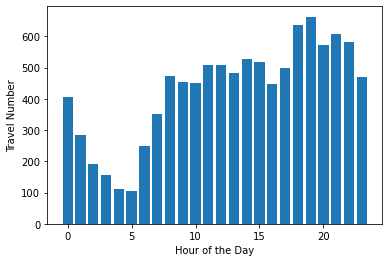

In [94]:
vis1_dataframe = get_data_for_visual_popular_hour()
plot_visual_popular_hour(vis1_dataframe)

### Visualization 2
- Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month) for both taxis and Ubers combined. Include the 90% confidence interval around the mean in the visualization.

In [95]:
def plot_visual_average_distance(dataframe):
    day_list = []
    count_list = []
    for d in dataframe:
        day_list.append(d[0])
        count_list.append(d[1])
    plt.bar(day_list, count_list)
    plt.xlabel("Month")
    plt.ylabel("Average distance")
    plt.show()

In [96]:
def get_data_for_visual_average_distance():
    
    QUERY_2 = '''
    SELECT MONTH, AVG(cal_distance) 
    FROM uber_trips 
    GROUP BY MONTH 
    '''
    res = engine.execute(QUERY_2).fetchall()
    return res
get_data_for_visual_average_distance()

[(1, 19.599886382401685),
 (2, 25.905721325307486),
 (3, 18.881069258674824),
 (4, 20.800346269789237),
 (5, 16.850271074290003),
 (6, 25.129434686092942),
 (7, 18.54798833371349),
 (8, 24.275012752394563),
 (9, 19.74020866730061),
 (10, 21.451769993222914),
 (11, 22.15537547250003),
 (12, 17.875100489939264)]

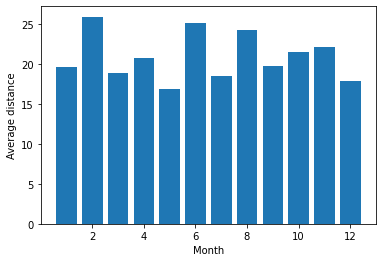

In [97]:
vis2_dataframe = get_data_for_visual_average_distance()
plot_visual_average_distance(vis2_dataframe)

### Visualization 3
- Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport. 

- Query steps:
- 1. By bboxfinder, we find latitude and longitude of LGA, JFK, and EWR
- 2. Select DAY, WEEK and compare distance of each data on LGA, JFK or EWR

In [98]:
def plot_visual_popular_dropoffs_day(some_dataframe):
    pass

In [99]:
def get_data_for_visual_popular_dropoffs_day():
    pass

In [100]:
vis3_dataframe = get_data_for_visual_popular_dropoffs_day()
plot_visual_popular_dropoffs_day(vis3_dataframe)

### Visualization 4
- Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

- Query steps:
- 1. Select taxi_trips and uber_trips
- 2. Return all pickup_lat, pickup_lon, dropoff_lat, dropoff_lon
- 3. Use KeplerGl to show all points

In [113]:
def plot_visual_all_trips_heatmap(some_dataframe):
    from keplergl import KeplerGl 
    map_1 = KeplerGl(height=500)
    map_1.add(some_dataframe)

In [114]:
def get_data_for_visual_all_trips_heatmap():
    
    QUERY_4 = '''
    SELECT *
    FROM taxi_trips  
    '''
    res = engine.execute(QUERY_4).fetchall()
    return res
get_data_for_visual_all_trips_heatmap()

[(0, 0, 1, '2015-01-29 18:59:06.000000', '2015-01-29 19:05:18.000000', 1, 0.9, 1, 'N', 262, 236, 1, 6.0, 1.0, 0.5, 1.95, 0.0, 0.3, 9.75, -73.94651035601463, 40.775932403149945, -73.95701169835736, 40.78043643718997, 2015, 1, 29, 18, 4, 1.0173519876288575),
 (1, 1, 2, '2015-01-08 22:59:42.000000', '2015-01-08 23:04:00.000000', 1, 1.04, 1, 'N', 255, 256, 1, 5.5, 0.5, 0.5, 0.0, 0.0, 0.3, 6.8, -73.95741813122187, 40.71880391812993, -73.95990462730533, 40.7108799333774, 2015, 1, 8, 22, 4, 0.906700808799683),
 (2, 2, 2, '2015-01-06 08:41:30.000000', '2015-01-06 09:05:51.000000', 5, 1.41, 1, 'N', 237, 50, 1, 15.0, 0.0, 0.5, 1.0, 0.0, 0.3, 16.8, -73.96563453538072, 40.76861518381155, -73.99513522075519, 40.766237725041876, 2015, 1, 6, 8, 2, 2.501233475028372),
 (3, 3, 1, '2015-01-22 14:44:21.000000', '2015-01-22 14:54:12.000000', 1, 1.1, 1, 'N', 68, 164, 2, 7.5, 0.0, 0.5, 0.0, 0.0, 0.3, 8.3, -73.99991742024713, 40.748427555065724, -73.98515639467684, 40.74857462935672, 2015, 1, 22, 14, 4, 1.24

In [115]:
vis4_dataframe = get_data_for_visual_all_trips_heatmap()
plot_visual_all_trips_heatmap(vis4_dataframe)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


AttributeError: 'KeplerGl' object has no attribute 'add'

### Visualization 5
- Create a scatter plot that compares tip amount versus distance for Yellow Taxi rides. You may remove any outliers how you see fit.

- Query steps:
- 1. Select taxi_trips
- 2. Return tip_amount and cal_distance
- 3. Show scatter about tip_amount and cal_distance

In [104]:
def plot_visual_tip_distance(dataframe):
    day_list = []
    count_list = []
    for d in dataframe:
        day_list.append(d[0])
        count_list.append(d[1])
#     plt.bar(day_list, count_list)

    plt.xlabel("tip_amount")
    plt.ylabel("distance")
    plt.scatter(day_list, count_list)
    plt.plot(count_list, count_list, 'o')    
    plt.show()

In [105]:
def get_data_for_visual_tip_distance():
    
    QUERY_5 = '''
    SELECT tip_amount, cal_distance
    FROM taxi_trips 
    '''
    res = engine.execute(QUERY_5).fetchall()
    return res
get_data_for_visual_tip_distance()

[(1.95, 1.0173519876288575),
 (0.0, 0.906700808799683),
 (1.0, 2.501233475028372),
 (0.0, 1.2449588104389195),
 (0.0, 2.635660901812626),
 (6.0, 13.566771550283342),
 (0.0, 6.294222933049586),
 (0.0, 8.265874215673906),
 (0.0, 2.5102209950401924),
 (0.95, 2.5256231153191635),
 (0.0, 0.808908440924804),
 (0.0, 3.461315625122713),
 (1.8, 1.2182478049712748),
 (0.0, 0.5479850987933226),
 (0.0, 4.912240271798466),
 (2.15, 0.5770436080999164),
 (0.0, 8.553617718774982),
 (4.5, 3.0775949523818356),
 (3.3, 3.8647792503714333),
 (0.0, 2.0131828622814543),
 (1.0, 1.3033231321080339),
 (2.15, 1.4661288215580672),
 (3.55, 5.860133094443296),
 (0.0, 28.21919469404428),
 (0.0, 3.960514501026447),
 (1.0, 1.5033583701399744),
 (14.5, 20.10576974515154),
 (1.2, 2.9480401940717833),
 (0.95, 0.0),
 (0.0, 1.2288475026694075),
 (0.0, 1.5730800780556595),
 (9.47, 9.983330945634929),
 (2.06, 1.8214742473734185),
 (1.1, 1.1029282312763449),
 (0.0, 0.755028955047921),
 (0.0, 1.7669918822345578),
 (2.35, 2.246

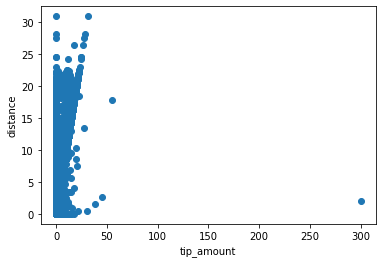

In [106]:
vis5_dataframe = get_data_for_visual_tip_distance()
plot_visual_tip_distance(vis5_dataframe)

### Visualization 6
- Create another scatter plot that compares tip amount versus precipitation amount for Yellow Taxi rides. You may remove any outliers how you see fit.

- Query steps:
- 1. Union taxi_trips and hourly_weather by hour column
- 2. Select taxi_trips.tip_amount and hourly_weather.hourly_precipitation
- 3. Show scatter tip_amount and hourly_precipitation

In [107]:
def plot_visual_tip_precipitation(dataframe):
    day_list = []
    count_list = []
    for d in dataframe:
        day_list.append(d[0])
        count_list.append(d[1])
    plt.bar(day_list, count_list)
    plt.xlabel("Month")
    plt.ylabel("Average distance")
    plt.show()

In [108]:
def get_data_for_visual_tip_precipitation():
    
    QUERY_6 = '''
    SELECT tip_amount, AVG(cal_distance) 
    FROM taxi_trips 
    GROUP BY MONTH 
    '''
    res = engine.execute(QUERY_6).fetchall()
    return res
get_data_for_visual_tip_precipitation()

[(1.95, 3.2908777202719763),
 (2.16, 3.2019198332921737),
 (0.0, 3.4806969426048737),
 (0.0, 3.4650868742786765)]

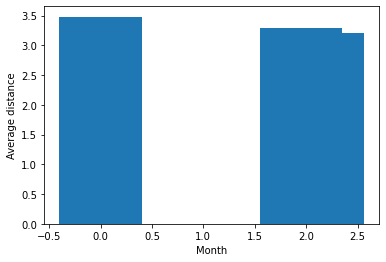

In [109]:
vis6_dataframe = get_data_for_visual_tip_precipitation()
plot_visual_tip_precipitation(vis6_dataframe)